# Migliore di Tutti

## Import Library

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from operator import itemgetter
from typing import List
import scipy.stats
import seaborn as sn
plt.style.use('ggplot')

## Class and Method

In [2]:
class ItemRank(object):
    """
    This class ranks Pandas dataframes using a specific field and implementing different ranking methodologies
    """
    def __init__(self, 
                 dataframe=pd.DataFrame,
                 df_key=List[str], 
                 rating=None,
                 m=None, 
                 C=None,  **args):
        self.data = dataframe
        self.df_key = df_key
        self.rating = rating
        self.prior = m
        self.confidence = C
        
    @property
    def items(self):
        ##Returns the data grouped by items
        return self.data.groupby(self.df_key)

    def get_means(self):
        return self.items[self.rating].mean()

    def get_counts(self):
        return self.items[self.rating].count()
    
    def plot_mean_frequency(self):
        grid   = pd.DataFrame({
                    'Mean Rating':  self.items[self.rating].mean(),
                    'Number of Reviews': self.items[self.rating].count()
                 })
        grid.plot(x='Number of Reviews', y='Mean Rating', kind='hexbin',
                  xscale='log', cmap='YlGnBu', gridsize=12, mincnt=1,
                  title="Ratings by Simple Mean")
        plt.show()
    
    def bayesian_mean(self, arr):
        if not self.prior or not self.confidence:
            raise TypeError("Bayesian mean must be computed with m and C")

        return ((self.confidence * self.prior + arr.sum()) /
                (self.confidence + arr.count()))
    
    def get_bayesian_estimates(self):
        return self.items[self.rating].agg(self.bayesian_mean)
    
    def top_items(self, n=10):
        table   = pd.DataFrame({
                    'mean':  self.get_means(),
                    'count': self.get_counts(),
                    'bayes': self.get_bayesian_estimates()
                    
                 })
        return table.sort_values('mean', ascending = False)[:n]

    def get_rank(self,rating_method='avg',ascending = True):
        if rating_method == 'bayes':
            table   = pd.DataFrame({
                    'count': self.get_counts(),
                    'rating': self.get_bayesian_estimates()
                 })
        elif rating_method == 'avg':
            table   = pd.DataFrame({
                    'count': self.get_counts(),
                    'rating': self.get_means()
                 }).reset_index(level=self.df_key)
        table1 = table.sort_values(['rating', 'count', 'game'], ascending=False).reset_index() 
        table1['rank'] = table1.index + 1
        return table1.sort_values('rank')

In [3]:
def rank_comparison(df,rating_1,rating_2,count_1,count_2,rank_1,rank_2, title_1, n1, n2):
    
    fig, ax = plt.subplots(figsize=(16, 18), nrows=2, ncols=3)
    
    # heat map for the correlation of Spearman, Pearson and Kendall
    r, s, k = (df[[rating_1,rating_2]].corr(), df[[rating_1,rating_2]].corr(method='spearman'), df[[rating_1,rating_2]].corr(method='kendall'))
    sn.set(font_scale=1.0)
    sn.heatmap(r, vmin=-1, vmax=1, annot=True, annot_kws={"size": 16}, ax=ax[0,0]).set_title("Pearson-on mean", fontweight='bold')
    sn.heatmap(s, vmin=-1, vmax=1, annot=True, annot_kws={"size": 16}, ax=ax[0,1]).set_title("Spearman-on rank", fontweight='bold')
    sn.heatmap(k, vmin=-1, vmax=1, annot=True, annot_kws={"size": 16}, ax=ax[0,2]).set_title("Kendall-on rank", fontweight='bold')    
           
    # bar chart of the top n1 games of rank_1 with their number of reviews
    ax[1,0].bar(df.sort_values(rank_1)[rank_1][:n1], df.sort_values(rank_1)[count_1][:n1], color='#7f6d5f')
    ax[1,0].set_title(rank_1, fontweight='bold')
    ax[1,0].set_xlabel('Rank', fontweight='bold')
    ax[1,0].set_ylabel('Reviews', fontweight='bold')
    
    # bar chart of the top n1 games of rank_2 with their number of reviews
    ax[1,1].bar(df.sort_values(rank_2)[rank_2][:n1], df.sort_values(rank_2)[count_2][:n1], color='#557f2d')
    ax[1,1].set_title(rank_2, fontweight='bold')
    ax[1,1].set_xlabel('Rank', fontweight='bold')
    ax[1,1].set_ylabel('Reviews', fontweight='bold')
    
    # bar chart comparing the ratings of the top np2 games in the rank_1 with their rating according to the rank_2
    t = df.sort_values(rank_1)
    i = t[rank_1][0:n2].index.tolist()
    x = df[title_1].iloc[i].tolist()
    y = df[rating_1].iloc[i].tolist()
    y1 = df[rating_2].iloc[i].tolist()
    
    barWidth = 0.25
    r1 = np.arange(len(y))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    plt.bar(r1, y, color='#7f6d5f', width=barWidth, edgecolor='white', label=rank_1)
    plt.bar(r2, y1, color='#557f2d', width=barWidth, edgecolor='white', label=rank_2)
    
    plt.title('top ' + str(n2) + ' of '+ rank_1, fontweight='bold')
    plt.xlabel('game', fontweight='bold')
    plt.ylabel('rating', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(y))], x, rotation=45, horizontalalignment='right')
    plt.legend()   



    plt.show()

## Data Exploration

In [4]:
# file path
bgg = 'data/bgg.csv'

In [5]:
#import data
df = pd.read_csv(bgg)

In [6]:
df.dtypes

game        int64
title      object
rating    float64
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082167 entries, 0 to 1082166
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   game    1082167 non-null  int64  
 1   title   1082167 non-null  object 
 2   rating  706813 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 24.8+ MB


In [8]:
df.head()

,game,title,rating
0,25984,Trivial Pursuit: Genus IV – Canadian Edition,3.0
1,25984,Trivial Pursuit: Genus IV – Canadian Edition,5.0
2,25984,Trivial Pursuit: Genus IV – Canadian Edition,3.0
3,25984,Trivial Pursuit: Genus IV – Canadian Edition,7.0
4,25984,Trivial Pursuit: Genus IV – Canadian Edition,6.0


In [9]:
df['rating'].describe().apply("{0:.5f}".format)

count    706813.00000
mean          6.42343
std           1.90770
min           0.00000
25%           5.00000
50%           6.95000
75%           8.00000
max          10.00000
Name: rating, dtype: object

In [10]:
df.isna().any()

game      False
title     False
rating     True
dtype: bool

In [11]:
df['rating'].nunique()

1650

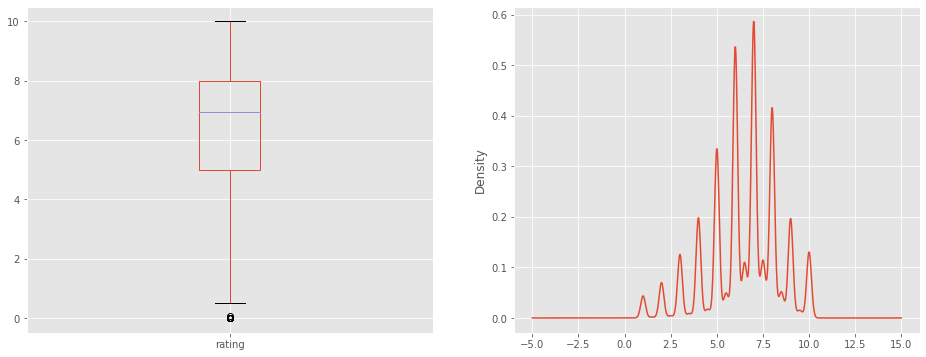

In [12]:
fig, ax = plt.subplots(figsize=(16, 6),nrows=1, ncols=2)
df[['rating']].boxplot(ax=ax[0])
df['rating'].plot.kde(ax=ax[1])
plt.show()

## ranking with bayes

In [13]:
ratings = ItemRank(df,df_key= ['game','title'], rating = 'rating',m=6.3,C=30)

                                        mean  count     bayes
game  title                                                  
13738 Aftermath                         10.0      1  6.419355
8083  Cowgirls                          10.0      1  6.419355
29345 David Dickinson's Antique Chase   10.0      1  6.419355
12216 Rumble                            10.0      1  6.419355
27836 Baseball Mania                    10.0      1  6.419355
1486  Plunder                           10.0      7  7.000000
24824 Retinue: Medieval Skirmish Rules  10.0      4  6.735294
9276  Medieval Warfare                  10.0      1  6.419355
10992 Zamitar                           10.0      1  6.419355
15960 Damon Hill Motorsport Board Game  10.0      1  6.419355


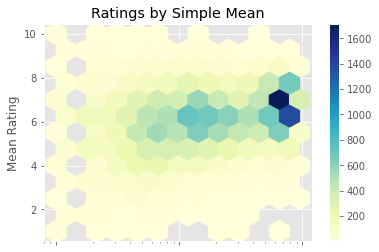

None


In [14]:
print (ratings.top_items(n=10))
print (ratings.plot_mean_frequency())

In [15]:
bayes_rank = ratings.get_rank(rating_method='bayes',ascending= False)

In [16]:
bayes_rank[:10]

,game,title,count,rating,rank
0,261393,Dungeon Universalis,79,8.739817,1
1,228370,TerroriXico,43,8.438356,2
2,240271,Core Space,76,8.338679,3
3,259061,Skytear,69,8.317172,4
4,245240,Goblin Grapple,88,8.226271,5
5,266507,Clank! Legacy: Acquisitions Incorporated,72,8.212909,6
6,115746,War of the Ring: Second Edition,74,8.165385,7
7,209877,World At War 85: Storming the Gap,47,8.158442,8
8,194923,Techno Bowl: Arcade Football Unplugged,80,8.137545,9
9,284111,Drinks & Daggers,45,8.106667,10


## Complete BBG Dataset

In [17]:
bgg_true = pd.read_csv('data/bgg_true_stats.csv')
bgg_true.head()

,game,title,rank,rating,count
0,25984,Trivial Pursuit: Genus IV – Canadian Edition,Not Ranked,Not Ranked,29
1,103339,Reluctant Enemies: Operation Exporter,3419,5.82593,259
2,132758,Fool's Gold,3388,5.82964,458
3,16497,Rat Hot,3498,5.81678,1019
4,195194,Horizons,3318,5.83852,544


In [18]:
bgg_true_filtered= bgg_true[bgg_true['rank']!='Not Ranked']

In [19]:
bgg_true_filtered

,game,title,rank,rating,count
1,103339,Reluctant Enemies: Operation Exporter,3419,5.82593,259
2,132758,Fool's Gold,3388,5.82964,458
3,16497,Rat Hot,3498,5.81678,1019
4,195194,Horizons,3318,5.83852,544
5,755,Thunder at Cassino,3556,5.80937,406
...,...,...,...,...,...
23913,2308,Atlantis: Pathways of the Deep,19257,5.4535,63
23914,9090,My First UNO,19193,5.4564,116
23915,14383,Wonders of the World,19366,5.44789,69
23916,8499,Bowl and Score,19290,5.45199,63


In [20]:
bgg_true_filtered['rating'] = pd.to_numeric(bgg_true_filtered['rating'])
bgg_true_filtered['rank'] = pd.to_numeric(bgg_true_filtered['rank'])

<ipython-input-20-d8ef1f4d7534>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bgg_true_filtered['rating'] = pd.to_numeric(bgg_true_filtered['rating'])
<ipython-input-20-d8ef1f4d7534>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bgg_true_filtered['rank'] = pd.to_numeric(bgg_true_filtered['rank'])


In [21]:
bgg_true_filtered.count()

game      17008
title     17008
rank      17008
rating    17008
count     17008
dtype: int64

## Bayes vs Bgg

In [22]:
full_df=pd.merge(bayes_rank, bgg_true_filtered, how="inner", on=["game","game"])

In [23]:
full_df.head()

,game,title_x,count_x,rating_x,rank_x,title_y,rank_y,rating_y,count_y
0,261393,Dungeon Universalis,79,8.739817,1,Dungeon Universalis,2705,5.94388,437
1,228370,TerroriXico,43,8.438356,2,TerroriXico,15911,5.50442,71
2,240271,Core Space,76,8.338679,3,Core Space,2125,6.06569,597
3,259061,Skytear,69,8.317172,4,Skytear,2896,5.90234,429
4,245240,Goblin Grapple,88,8.226271,5,Goblin Grapple,14371,5.51495,174


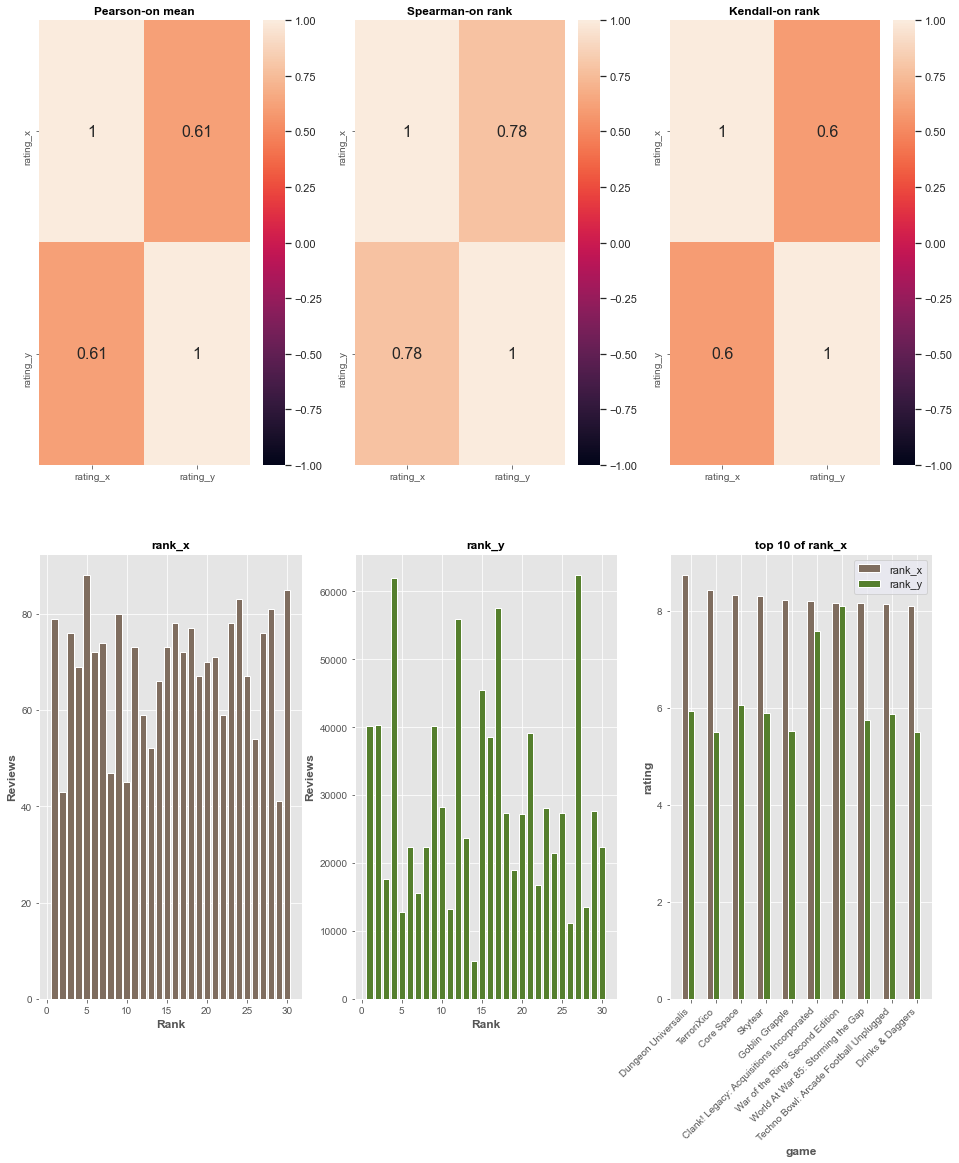

In [24]:
rank_comparison(df=full_df,rating_1='rating_x',rating_2='rating_y',count_1='count_x',count_2='count_y',
                rank_1='rank_x',rank_2='rank_y', title_1='title_x', n1=30, n2=10)

## Avg vs Bgg

In [25]:
avg_rank = ratings.get_rank(rating_method='avg',ascending= False)

In [26]:
full_df_avg=pd.merge(avg_rank, bgg_true_filtered, how="inner", on=["game","game"])

In [27]:
full_df_avg.head()

,index,game,title_x,count_x,rating_x,rank_x,title_y,rank_y,rating_y,count_y
0,21830,228370,TerroriXico,43,9.930233,13,TerroriXico,15911,5.50442,71
1,23276,264858,Moonshine Empire,25,9.700000,15,Moonshine Empire,14827,5.51177,43
2,22206,235695,Frontier: The Card Game,26,9.692308,16,Frontier: The Card Game,17717,5.48842,35
3,23650,281257,Aeolis,13,9.692308,17,Aeolis,13520,5.52042,35
4,18113,147635,Dungeon Crusade: Book I – Genesis of Evil,15,9.666667,18,Dungeon Crusade: Book I – Genesis of Evil,11641,5.53416,42


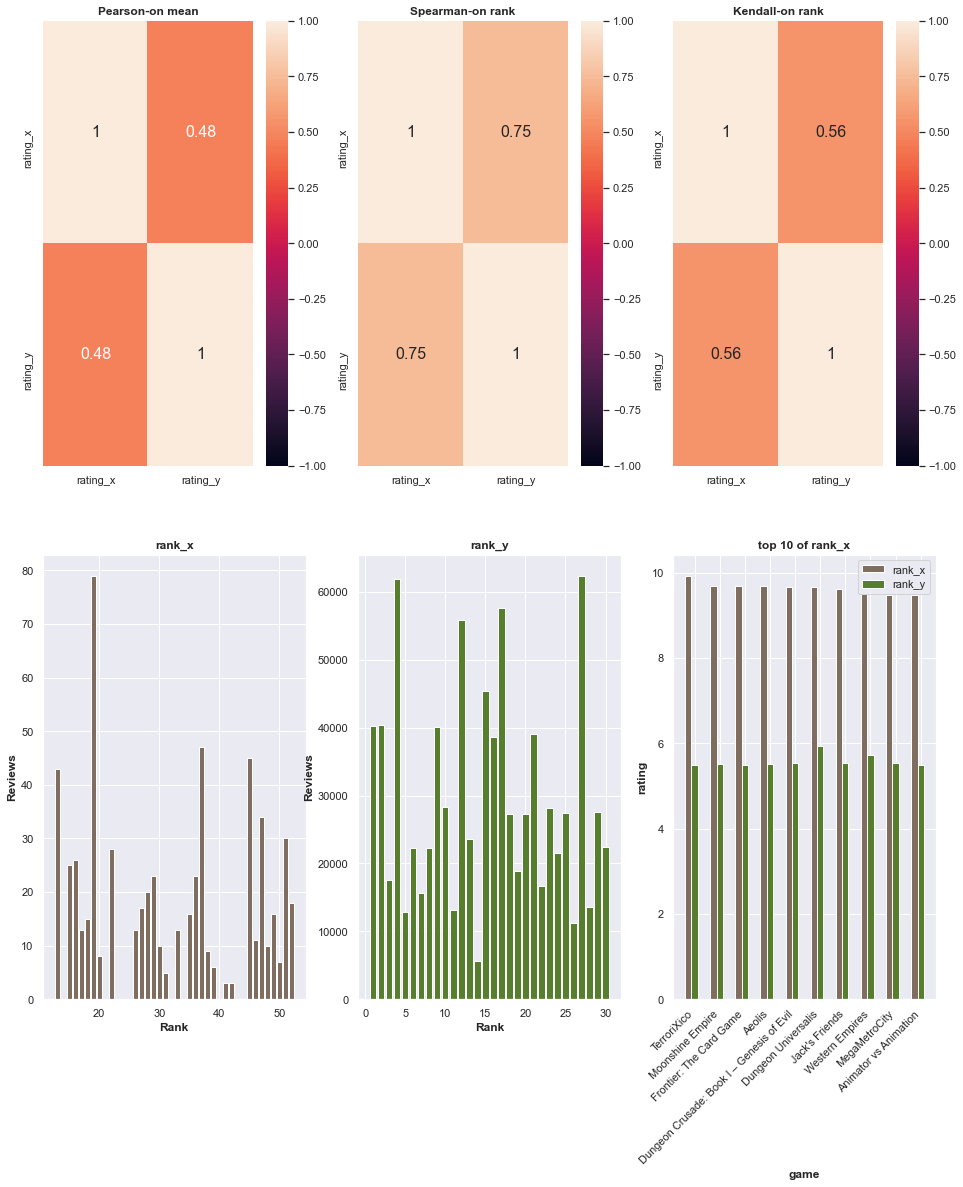

In [28]:
rank_comparison(df=full_df_avg,rating_1='rating_x',rating_2='rating_y',count_1='count_x',count_2='count_y',
                rank_1='rank_x',rank_2='rank_y', title_1='title_x', n1=30, n2=10)

## Avg vs Bayes

In [29]:
full_Avg_B = pd.merge(avg_rank, bayes_rank, how="inner", on=["game","game"])

In [30]:
full_Avg_B.head()

,index,game,title_x,count_x,rating_x,rank_x,title_y,count_y,rating_y,rank_y
0,1114,1486,Plunder,7,10.0,1,Plunder,7,7.000000,1854
1,12417,24824,Retinue: Medieval Skirmish Rules,4,10.0,2,Retinue: Medieval Skirmish Rules,4,6.735294,3729
2,8723,13831,The Communication in Catan,3,10.0,3,The Communication in Catan,3,6.636364,4711
3,8791,13997,Junk,2,10.0,4,Junk,2,6.531250,6071
4,13622,29345,David Dickinson's Antique Chase,1,10.0,5,David Dickinson's Antique Chase,1,6.419355,8055


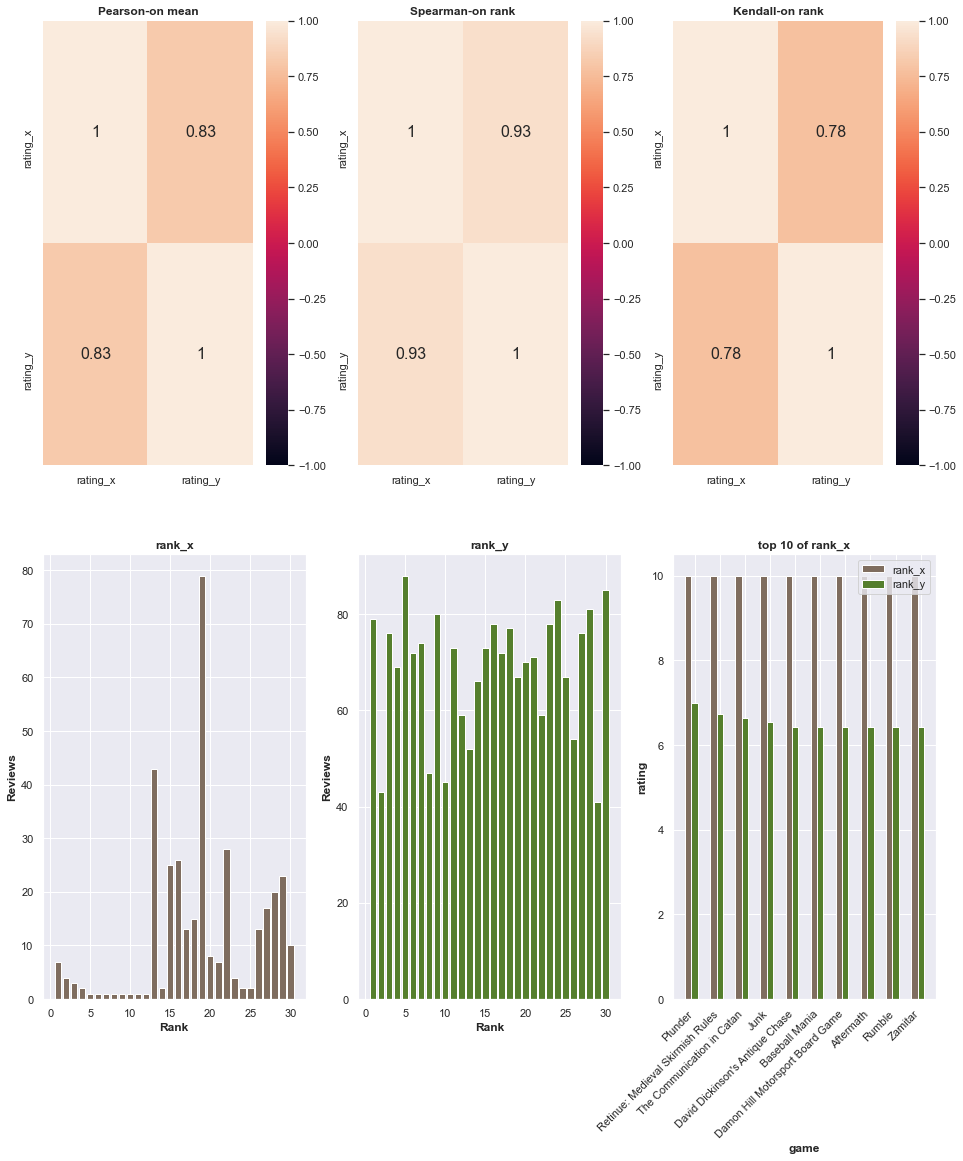

In [31]:
rank_comparison(df=full_Avg_B,rating_1='rating_x',rating_2='rating_y',count_1='count_x',count_2='count_y',
                rank_1='rank_x',rank_2='rank_y', title_1='title_x', n1=30, n2=10)